# LearnX Sales Forecasting

---
### Problem Statement:
    
LearnX is an online learning platform aimed at professionals and students. LearnX serves as a market place that allows instructors to build online courses on topics of their expertise which is later published after due diligence by the LearnX team. The platform covers a wide variety of topics including Development, Business, Finance & Accounting & Software Marketing and so on

Effective forecasting for course sales gives essential insight into upcoming cash flow meaning business can more accurately plan the budget to pay instructors and other operational costs and invest in the expansion of the business.

Sales data for more than 2 years from 600 courses of LearnX's top domains is available along with information on

    Competition in the market for each course
    Course Type (Course/Program/Degree)
    Holiday Information for each day
    User Traffic on Course Page for each day
    Your task is to predict the course sales for each course in the test set for the next 60 days

---


### Data Dictionary


---

Data Dictionary

Train (Historical Sales Data)

    Variable	           Definition
    ID	                Unique Identifier for a row
    Day_No	            Day Number
    Course_ID	        Unique ID for a course
    Course_Domain	    Course Domain (Development, Finance etc.)
    Course_Type	        Course/Program/Degree
    Short_Promotion	    Whether Short Term Promotion is Live
    Public_Holiday	    Regional/Public Holiday
    Long_Promotion	    Whether Long Term Promotion is Live for the course
    User_Traffic	    Number of customers landing on the course page
    Competition_Metric	A metric defining the strength of competition 
    Sales	            (Target) Total Course Sales

---
Test (next 60 days)


    Variable	         Definition
    ID	              Unique Identifier for a row
    Day_No	          Day Number
    Course_ID	      Unique ID for a course
    Course_Domain	  Course Domain (Development, Finance etc.)
    Course_Type	      Course/Program/Degree
    Short_Promotion	  Whether Short Term Promotion is Live
    Public_Holiday	  Regional/Public Holiday
    Long_Promotion	  Whether Long Term Promotion is Live for the course
    Competition_Metric	A metric defining the strength of competition
    
   ---


## Index:

       1. Data import
       2. Data validation
       3. Null value imputation
       4. UVA
       5. BVA
       6. Model building
       7. Tuning
       8. Result submission

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import math
from sklearn.model_selection import train_test_split

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import catboost
import lightgbm
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tqdm

In [2]:
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# defining evaluation metric:
def rmsle_t(actual, predicted):
    return 1000*(np.sqrt(np.mean((np.power(np.log(np.array(actual)+1) -
                                           np.log(np.array(predicted)+1), 2)))
                        ))


### Importing the data

In [4]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Data imported')

Data imported


In [5]:
test_orig = pd.read_csv('test.csv')

In [6]:
data.shape, test.shape

((512087, 11), (36000, 9))

In [7]:
# check a sample of train data
data.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,3,1,Development,Course,0,0,1,11655,0.007,75
3,4,4,1,Development,Course,0,0,1,12054,0.007,80
4,5,5,1,Development,Course,0,0,1,6804,0.007,41


In [8]:
test.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric
0,883,883,1,Development,Course,1,0,1,0.007
1,884,884,1,Development,Course,1,0,1,0.007
2,885,885,1,Development,Course,1,0,1,0.007
3,886,886,1,Development,Course,1,0,1,0.007
4,887,887,1,Development,Course,0,0,1,0.007


## Data validation

Check for data types

In [9]:
data.dtypes

ID                      int64
Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
dtype: object

In [10]:
data.nunique()

ID                    512087
Day_No                   882
Course_ID                600
Course_Domain              4
Course_Type                3
Short_Promotion            2
Public_Holiday             2
Long_Promotion             2
User_Traffic            3475
Competition_Metric       196
Sales                    544
dtype: int64

In [11]:
test.nunique()

ID                    36000
Day_No                   60
Course_ID               600
Course_Domain             4
Course_Type               3
Short_Promotion           2
Public_Holiday            2
Long_Promotion            2
Competition_Metric      196
dtype: int64

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,512087.0,274007.300650,158228.834029,1.0,136962.50,273984.000,411065.500,548027.000
Day_No,512087.0,434.917869,256.044161,1.0,214.00,427.000,658.000,882.000
Course_ID,512087.0,300.388344,173.365787,1.0,150.00,300.000,451.000,600.000
Short_Promotion,512087.0,0.380244,0.485447,0.0,0.00,0.000,1.000,1.000
Public_Holiday,512087.0,0.031639,0.175038,0.0,0.00,0.000,0.000,1.000
Long_Promotion,512087.0,0.488968,0.499879,0.0,0.00,0.000,1.000,1.000
User_Traffic,512087.0,15375.101198,7727.231205,168.0,10584.00,13776.000,18123.000,100002.000
Competition_Metric,510323.0,0.073345,0.100115,0.0,0.01,0.035,0.094,0.768
Sales,512087.0,120.826924,54.355258,0.0,84.00,111.000,146.000,682.000


---

    Day no        -    no of days - cont data
    Course_ID     -    unique id of course
    Course domain -    (Development, Software marketing, Finance & Accounting, Business)  -categorical data
    Course_Type   -    (Course, Program, Degree) - Categorical data
    Short_Promotion -  (0,1) - categorical data
    Public_Holiday  -  (0,1) - categorical data
    Long_Promotion  -  (0,1) - categorical data

---

    ID and Course ID being unique identifier

    Day_No - min- 1 to max - 882 representing each day
    User_Traffic - 
    Competition_Metric - Score given to the course based on the competition in market
    Sales - target variable, showing number of times course purchased.





--- 

User traffic and sales show most variance interms of data distribution, we might have to cap the outliers



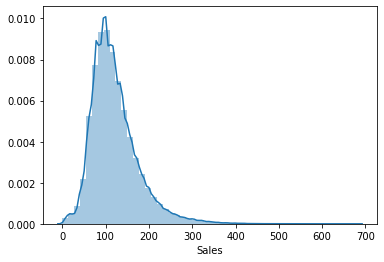

In [13]:
sns.distplot(data['Sales'])

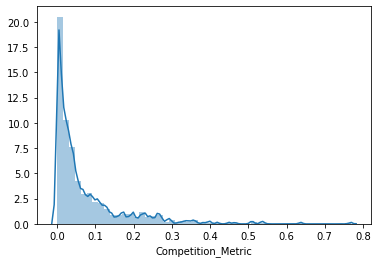

In [14]:
sns.distplot(data['Competition_Metric'])

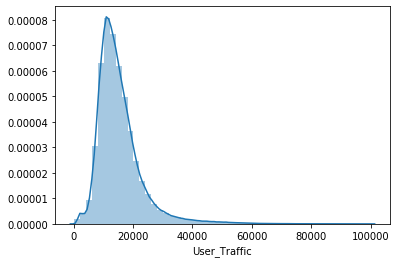

In [15]:
sns.distplot(data['User_Traffic'])

### Outlier Capping

In [16]:
## As sales & User Traffic is only avaialble in training data, uisng outlier capping in train data only ###
numeric_col= data[["User_Traffic","Sales","Competition_Metric"]]
for i in numeric_col:
    data.loc[data[i]>data[i].quantile(0.99),i]=data[i].quantile(0.99)
    data.loc[data[i]<data[i].quantile(0.01),i]=data[i].quantile(0.01)
data.describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
ID,512087.0,274007.300650,158228.834029,1.0,5421.86,27345.300,273984.000,520682.700,542546.140,548027.000
Day_No,512087.0,434.917869,256.044161,1.0,9.00,43.000,427.000,840.000,874.000,882.000
Course_ID,512087.0,300.388344,173.365787,1.0,6.00,30.000,300.000,571.000,594.000,600.000
Short_Promotion,512087.0,0.380244,0.485447,0.0,0.00,0.000,0.000,1.000,1.000,1.000
Public_Holiday,512087.0,0.031639,0.175038,0.0,0.00,0.000,0.000,0.000,1.000,1.000
Long_Promotion,512087.0,0.488968,0.499879,0.0,0.00,0.000,0.000,1.000,1.000,1.000
User_Traffic,512087.0,15295.651682,7222.328295,3780.0,3780.00,7035.000,13776.000,29064.000,46221.000,46221.000
Competition_Metric,510323.0,0.072579,0.095961,0.0,0.00,0.001,0.035,0.269,0.509,0.509
Sales,512087.0,120.477577,52.170514,27.0,27.00,54.000,111.000,222.000,304.000,304.000


In [17]:
### As Competition_Metric in both the tables , we can do outlier capping after combining these ####
numeric_col= test[["Competition_Metric"]]
for i in numeric_col:
    test.loc[test[i]>test[i].quantile(0.99),i]=test[i].quantile(0.99)

In [18]:
# data['Course_Domain'].value_counts()   #to be run one by one 
# data['Course_Type'].value_counts()
# data['Short_Promotion'].value_counts()
# data['Public_Holiday'].value_counts()
# data['Long_Promotion'].value_counts()
data['User_Traffic'].nunique()

2022

In [19]:
data.isnull().sum()

ID                       0
Day_No                   0
Course_ID                0
Course_Domain            0
Course_Type              0
Short_Promotion          0
Public_Holiday           0
Long_Promotion           0
User_Traffic             0
Competition_Metric    1764
Sales                    0
dtype: int64

In [20]:
test.isnull().sum()

ID                      0
Day_No                  0
Course_ID               0
Course_Domain           0
Course_Type             0
Short_Promotion         0
Public_Holiday          0
Long_Promotion          0
Competition_Metric    120
dtype: int64

In [21]:
# filtering data
bool_series = pd.isnull(data["Competition_Metric"])


# displayind data only with team = NaN
data[bool_series]['Course_ID'].value_counts()

354    882
176    882
Name: Course_ID, dtype: int64

In [22]:
# filtering data
bool_series = pd.isnull(test["Competition_Metric"])


# displayind data only with team = NaN
test[bool_series]['Course_ID'].value_counts()

354    60
176    60
Name: Course_ID, dtype: int64

In [23]:
data['Competition_Metric'].min(), data['Competition_Metric'].max()

(0.0, 0.509)

In [24]:
data[data['Competition_Metric']== 0.509]

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
60084,64285,1,71,Development,Program,0,1,0,9660.0,0.509,76.0
60085,64286,2,71,Development,Program,0,0,0,19110.0,0.509,120.0
60086,64287,3,71,Development,Program,0,0,0,13944.0,0.509,83.0
60087,64288,4,71,Development,Program,0,0,0,13587.0,0.509,95.0
60088,64289,5,71,Development,Program,0,0,0,15036.0,0.509,93.0
...,...,...,...,...,...,...,...,...,...,...,...
381369,408130,878,447,Software Marketing,Course,0,0,0,10521.0,0.509,91.0
381370,408131,879,447,Software Marketing,Course,0,0,0,12180.0,0.509,116.0
381371,408132,880,447,Software Marketing,Course,0,0,0,10101.0,0.509,84.0
381372,408133,881,447,Software Marketing,Course,0,0,0,10101.0,0.509,79.0


In [29]:
data[data['Competition_Metric']== 0.000000]

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
13744,14705,1,17,Development,Course,0,1,1,13104.0,0.0,134.0
13745,14706,2,17,Development,Course,0,0,1,19803.0,0.0,102.0
13746,14707,3,17,Development,Course,0,0,1,20727.0,0.0,112.0
13747,14708,4,17,Development,Course,0,0,1,16863.0,0.0,91.0
13748,14709,5,17,Development,Course,0,0,1,18858.0,0.0,101.0
...,...,...,...,...,...,...,...,...,...,...,...
464162,496743,878,544,Development,Program,0,0,0,13251.0,0.0,87.0
464163,496744,879,544,Development,Program,0,0,0,15813.0,0.0,109.0
464164,496745,880,544,Development,Program,0,0,0,14322.0,0.0,95.0
464165,496746,881,544,Development,Program,0,0,0,13398.0,0.0,82.0


In [30]:
test[test['Course_ID']==354]

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric
21180,324025,883,354,Development,Program,1,0,0,NaN
21181,324026,884,354,Development,Program,1,0,0,NaN
21182,324027,885,354,Development,Program,1,0,0,NaN
21183,324028,886,354,Development,Program,1,0,0,NaN
21184,324029,887,354,Development,Program,0,0,0,NaN
21185,324030,888,354,Development,Program,0,0,0,NaN
21186,324031,889,354,Development,Program,0,0,0,NaN
21187,324032,890,354,Development,Program,0,0,0,NaN
21188,324033,891,354,Development,Program,0,0,0,NaN
21189,324034,892,354,Development,Program,0,0,0,NaN


#### It seems, of all 600 courses, we do not have competition metric for two courses. Let's impute the values using mean 

In [31]:
#Should try to combine train and test to impute metric to check any improvements later

In [25]:
data["Competition_Metric"] = data.groupby(["Course_Domain","Course_Type"])["Competition_Metric"].transform(lambda x: 
                                                                                                           x.fillna(x.mean()))

In [26]:
test["Competition_Metric"] = test.groupby(["Course_Domain","Course_Type"])["Competition_Metric"].transform(lambda x: 
                                                                                                           x.fillna(x.mean()))

In [27]:
data.isnull().sum()

ID                    0
Day_No                0
Course_ID             0
Course_Domain         0
Course_Type           0
Short_Promotion       0
Public_Holiday        0
Long_Promotion        0
User_Traffic          0
Competition_Metric    0
Sales                 0
dtype: int64

In [28]:
test.isnull().sum()

ID                    0
Day_No                0
Course_ID             0
Course_Domain         0
Course_Type           0
Short_Promotion       0
Public_Holiday        0
Long_Promotion        0
Competition_Metric    0
dtype: int64

### Our  data: 

    train - data
    test - test

## Univariate Analysis (UVA)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  512087 non-null  int64  
 1   Day_No              512087 non-null  int64  
 2   Course_ID           512087 non-null  int64  
 3   Course_Domain       512087 non-null  object 
 4   Course_Type         512087 non-null  object 
 5   Short_Promotion     512087 non-null  int64  
 6   Public_Holiday      512087 non-null  int64  
 7   Long_Promotion      512087 non-null  int64  
 8   User_Traffic        512087 non-null  float64
 9   Competition_Metric  512087 non-null  float64
 10  Sales               512087 non-null  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 43.0+ MB


In [31]:
cat_cols =  ['Course_Domain','Course_Type','Short_Promotion','Public_Holiday',
             'Long_Promotion']
cont_cols = ['Day_No','User_Traffic','Competition_Metric','Sales']

In [32]:
def plot_cat(var, l=8,b=5):
    plt.figure( figsize = (l, b))
    sns.countplot(data[var], order = data[var].value_counts().index)

In [33]:
def plot_cont(var, l=8,b=5):
    plt.figure(figsize=(l, b))
    sns.distplot(data[var])
    plt.xlabel(var)

In [34]:
def plot_cont_kde(var, l=8,b=5):
    
    mini = data[var].min()
    maxi = data[var].max()
    ran = data[var].max()-data[var].min()
    mean = data[var].mean()
    skew = data[var].skew()
    kurt = data[var].kurtosis()
    median = data[var].median()
    st_dev = data[var].std()
    points = mean-st_dev, mean+st_dev
    
    fig, axes=plt.subplots(1,2)
    sns.boxplot(data=data,x=var, ax=axes[0])
    sns.distplot(a=data[var], ax=axes[1], color='#ff4125')
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini, maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    fig.set_size_inches(l,b)
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median =  {}'.format((round(points[0],2),round(points[1],2)),
    round(kurt,2),round(skew,2),(round(mini,2),round(maxi,2),
    round(ran,2)),round(mean,2), round(median,2)))

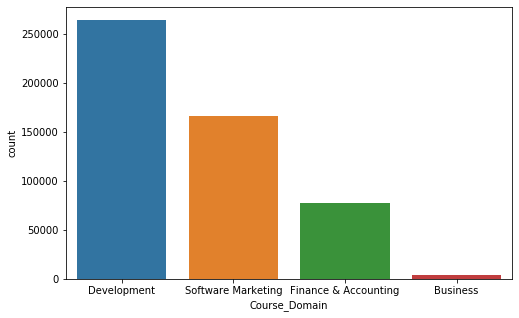

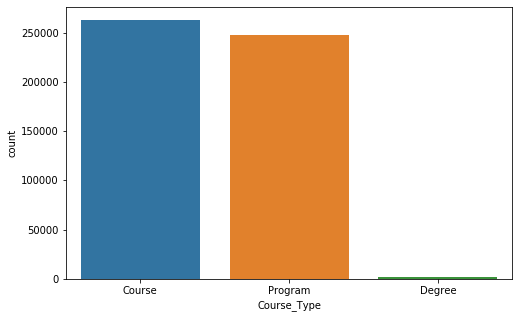

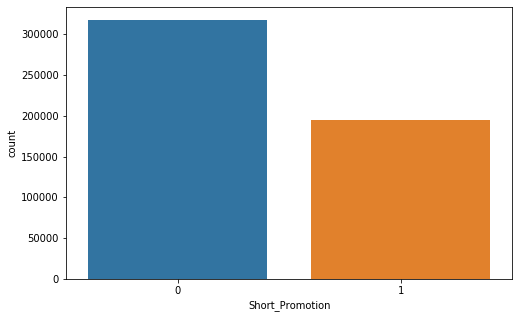

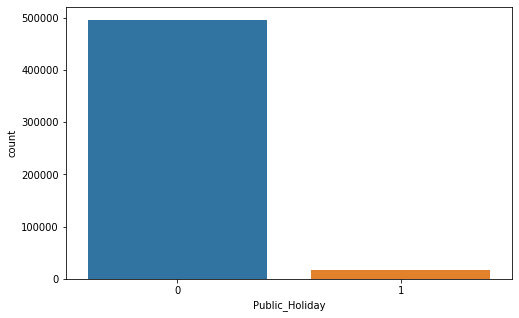

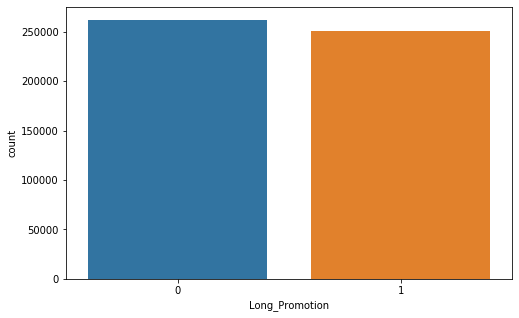

In [35]:
for i in cat_cols:
    plot_cat(i)

### Inferences:

    Course Domain - Max courses are for Development and least for Business.
    Course type - count of degree in total course available is pretty low
    

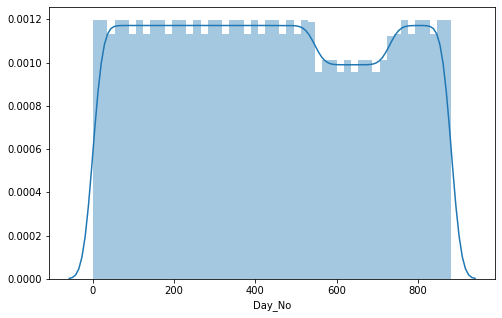

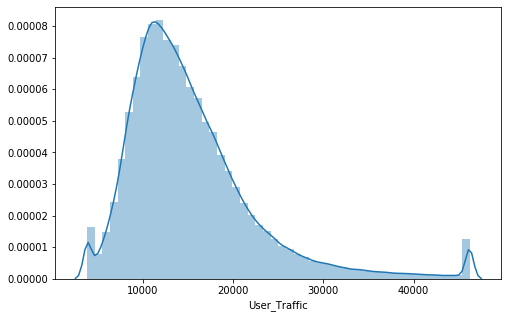

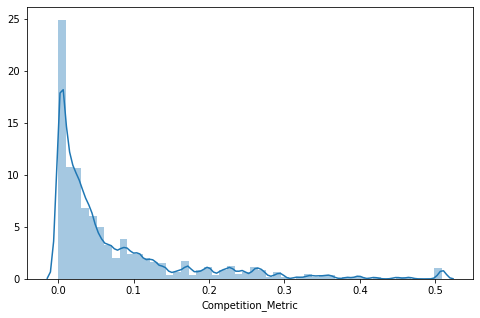

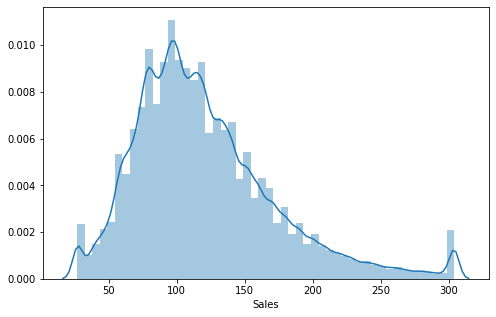

In [36]:
for i in cont_cols:
    plot_cont(i)

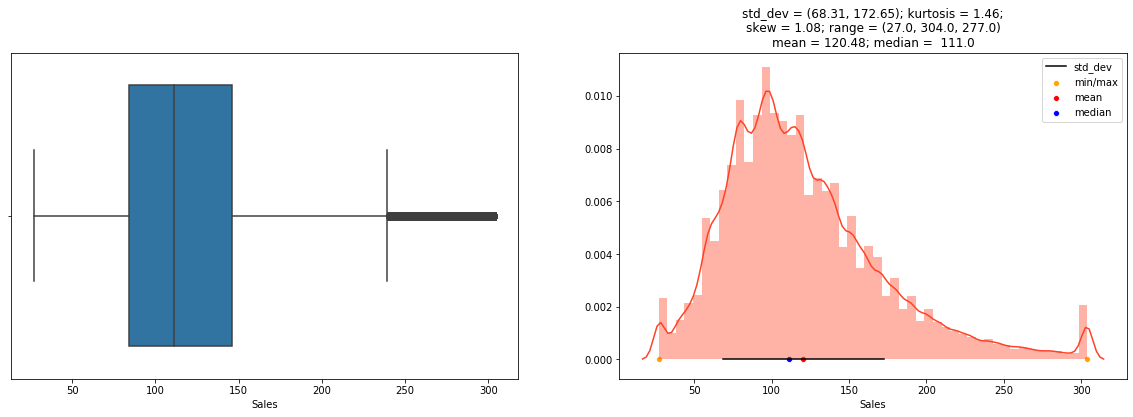

In [37]:
plot_cont_kde('Sales',20,6)

### Inferences:

After capping the outliers, Sales is giving a distribution similar to normal.


    

## BVA

### Cont-Cont

In [38]:
#Defining a function to calculate correlation among columns:
def corr_2_cols(Col1, Col2):
    res = pd.crosstab(data[Col1],data[Col2])
    # res = df1.groupby([Col1, Col2]).size().unstack()
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

In [39]:
cont_cols

['Day_No', 'User_Traffic', 'Competition_Metric', 'Sales']

<Figure size 840x560 with 0 Axes>

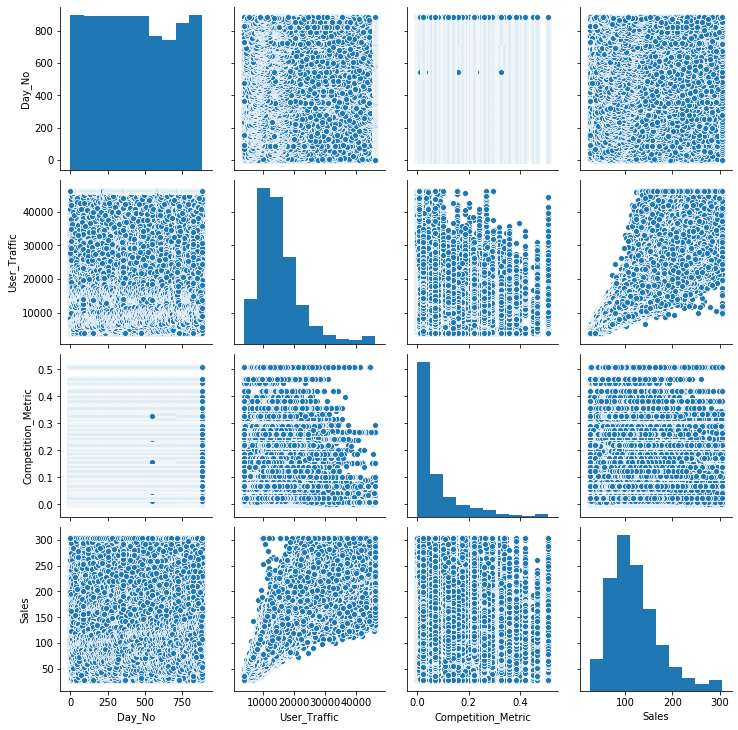

In [40]:
# scatter plot for transactional variables
plt.figure(dpi=140)
sns.pairplot(data[cont_cols])

In [41]:
correlation = data[cont_cols].corr()
correlation

,Day_No,User_Traffic,Competition_Metric,Sales
Day_No,1.000000,0.021338,0.003176,0.062157
User_Traffic,0.021338,1.000000,-0.156342,0.842259
Competition_Metric,0.003176,-0.156342,1.000000,-0.019415
Sales,0.062157,0.842259,-0.019415,1.000000


In [42]:
cor_mat= data.corr()
cor_with_tar=cor_mat.sort_values(['Sales'],ascending=False)
cor_with_tar["Sales"]

Sales                 1.000000
User_Traffic          0.842259
Short_Promotion       0.374855
Day_No                0.062157
ID                    0.018910
Course_ID             0.018763
Competition_Metric   -0.019415
Long_Promotion       -0.110404
Public_Holiday       -0.131280
Name: Sales, dtype: float64

In [37]:
df = data.copy()

In [38]:
#applying log to further check the correlation

In [39]:
#taking log of every value to negate outliers
for column in cont_cols:
  mini=1
  if data[column].min()<0:
    mini =  abs(df[column].min()) + 1
  
  df[column] = [i+mini for i in df[column]]
  df[column] = df[column].map(lambda x : np.log(x))

NameError: name 'cont_cols' is not defined

In [40]:
# scatter plot for transactional variables
plt.figure(dpi=140)
sns.pairplot(df[cont_cols])

NameError: name 'cont_cols' is not defined

<Figure size 840x560 with 0 Axes>

In [48]:
cont_cols

['Day_No', 'User_Traffic', 'Competition_Metric', 'Sales']

## Features

We can use Day_No to create further columns such as - year, month or week

Splitting dataset

In [30]:
X= data.drop(columns= 'Sales',axis=1)
y= data['Sales']
X_train ,X_val, y_train ,y_val  = train_test_split(X, y, random_state = 7)
col=X_train.columns

In [31]:
#year
data["Year_No"]=np.ceil(data["Day_No"]/365)
test["Year_No"]=np.ceil(test["Day_No"]/365)


In [32]:
# alligning day as per year
data["Year_Day_No"]=0
test["Year_Day_No"]=0

data.loc[data["Year_No"]==1,"Year_Day_No"]=data["Day_No"]
data.loc[data["Year_No"]==2,"Year_Day_No"]=data["Day_No"]-365
data.loc[data["Year_No"]==3,"Year_Day_No"]=data["Day_No"]-730

test.loc[test["Year_No"]==1,"Year_Day_No"]=test["Day_No"]
test.loc[test["Year_No"]==2,"Year_Day_No"]=test["Day_No"]-365
test.loc[test["Year_No"]==3,"Year_Day_No"]=test["Day_No"]-730

In [33]:
#month

data["Months"]=np.ceil(data["Year_Day_No"]/30)
test["Months"]=np.ceil(test["Year_Day_No"]/30)

data.loc[data["Months"]==13,"Months"]=12
test.loc[test["Months"]==13,"Months"]=12

In [34]:
#weeks 
data["Weeks"]=np.ceil(data["Year_Day_No"]/7)
test["Weeks"]=np.ceil(test["Year_Day_No"]/7)

data.loc[data["Weeks"]==53,"Weeks"]=52
test.loc[data["Weeks"]==53,"Weeks"]=52

In [35]:
data.sample(5)

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales,Year_No,Year_Day_No,Months,Weeks
250372,267953,43,294,Development,Course,0,0,1,16107.0,0.024,105.0,1.0,43,2.0,7.0
118856,127197,307,140,Development,Course,0,0,1,8652.0,0.075,76.0,1.0,307,11.0,44.0
382800,409681,545,449,Software Marketing,Course,0,0,1,9114.0,0.326,75.0,2.0,180,6.0,26.0
173568,185749,227,204,Development,Course,1,1,1,8568.0,0.001,63.0,1.0,227,8.0,33.0
404672,433113,589,475,Development,Course,0,0,1,11592.0,0.013,66.0,2.0,224,8.0,32.0


In [36]:
data['Months']=data['Months'].astype(int).astype(str)
data['Year_No'] = data['Year_No'].astype(int).astype(str)
data['Weeks'] = data['Weeks'].astype(int).astype(str)

test['Months']=test['Months'].astype(int).astype(str)
test['Year_No'] = test['Year_No'].astype(int).astype(str)
test['Weeks'] = test['Weeks'].astype(int).astype(str)


In [37]:
cols=data[['Course_Domain','Course_Type',"Year_No","Months","Weeks","Long_Promotion","Public_Holiday","Short_Promotion"]]
for i in cols:
    data[i]=data[i].astype('category')
    test[i]=test[i].astype('category')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   ID                  512087 non-null  int64   
 1   Day_No              512087 non-null  int64   
 2   Course_ID           512087 non-null  int64   
 3   Course_Domain       512087 non-null  category
 4   Course_Type         512087 non-null  category
 5   Short_Promotion     512087 non-null  category
 6   Public_Holiday      512087 non-null  category
 7   Long_Promotion      512087 non-null  category
 8   User_Traffic        512087 non-null  float64 
 9   Competition_Metric  512087 non-null  float64 
 10  Sales               512087 non-null  float64 
 11  Year_No             512087 non-null  category
 12  Year_Day_No         512087 non-null  int64   
 13  Months              512087 non-null  category
 14  Weeks               512087 non-null  category
dtypes: category(8), f

In [39]:
data_cb =data.copy()  #catboost data
test_cb = test.copy()

In [40]:
cor_mat= data.corr()
cor_with_tar=cor_mat.sort_values(['Sales'],ascending=False)
cor_with_tar["Sales"]

Sales                 1.000000
User_Traffic          0.842259
Year_Day_No           0.070269
Day_No                0.062157
ID                    0.018910
Course_ID             0.018763
Competition_Metric   -0.019415
Name: Sales, dtype: float64

In [41]:
data.sample(10)

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales,Year_No,Year_Day_No,Months,Weeks
419805,449326,398,493,Development,Program,0,0,0,13482.0,0.003,75.0,2,33,2,5
354250,379151,365,416,Software Marketing,Program,0,0,0,6153.0,0.025,45.0,1,365,12,52
123731,132372,772,145,Software Marketing,Course,0,0,1,6258.0,0.090,49.0,3,42,2,6
174458,186699,419,205,Development,Program,0,0,0,10626.0,0.106,96.0,2,54,2,8
410068,438869,693,481,Software Marketing,Course,1,0,1,12789.0,0.067,130.0,2,328,11,47
356765,381846,418,419,Software Marketing,Program,0,0,0,18291.0,0.157,114.0,2,53,2,8
207860,222381,857,243,Business,Course,1,0,0,29106.0,0.016,158.0,3,127,5,19
341141,365082,448,400,Development,Course,0,0,0,7329.0,0.001,50.0,2,83,3,12
19174,20495,139,23,Development,Course,0,0,1,14112.0,0.002,80.0,1,139,5,20
194233,207854,92,228,Development,Program,0,0,1,15645.0,0.001,83.0,1,92,4,14


In [42]:
test.sample(5)

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Year_No,Year_Day_No,Months,Weeks
34881,531461,904,582,Software Marketing,Program,0,0,1,0.009,3,174,6,25
8830,135135,893,148,Development,Program,0,0,0,0.017,3,163,6,24
32856,500368,919,548,Software Marketing,Program,0,0,1,0.130,3,189,7,27
11591,176996,894,194,Software Marketing,Program,0,0,1,0.110,3,164,6,24
19455,297458,898,325,Software Marketing,Course,1,0,1,0.028,3,168,6,24


In [72]:
data.shape, test.shape

((512087, 15), (36000, 13))

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   ID                  512087 non-null  int64   
 1   Day_No              512087 non-null  int64   
 2   Course_ID           512087 non-null  int64   
 3   Course_Domain       512087 non-null  category
 4   Course_Type         512087 non-null  category
 5   Short_Promotion     512087 non-null  category
 6   Public_Holiday      512087 non-null  category
 7   Long_Promotion      512087 non-null  category
 8   User_Traffic        512087 non-null  float64 
 9   Competition_Metric  512087 non-null  float64 
 10  Sales               512087 non-null  float64 
 11  Year_No             512087 non-null  category
 12  Year_Day_No         512087 non-null  int64   
 13  Months              512087 non-null  category
 14  Weeks               512087 non-null  category
dtypes: category(8), f

In [75]:
data.columns, test.columns


(Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
        'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
        'Competition_Metric', 'Sales', 'Year_No', 'Year_Day_No', 'Months',
        'Weeks'],
       dtype='object'),
 Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
        'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
        'Competition_Metric', 'Year_No', 'Year_Day_No', 'Months', 'Weeks'],
       dtype='object'))

# Model

### As we do not have user traffic column in test so - First step, we need to predict the User traffic column 

In [43]:
data_cb.columns, test_cb.columns


(Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
        'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
        'Competition_Metric', 'Sales', 'Year_No', 'Year_Day_No', 'Months',
        'Weeks'],
       dtype='object'),
 Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
        'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
        'Competition_Metric', 'Year_No', 'Year_Day_No', 'Months', 'Weeks'],
       dtype='object'))

In [44]:
data_cb.drop(columns=['Sales','ID','Course_ID'],axis=1, inplace=True)
test_cb.drop(columns=['ID','Course_ID'],axis=1, inplace=True)


In [45]:
cols=data_cb[["Year_No","Months","Weeks","Long_Promotion","Public_Holiday","Short_Promotion",'Course_Domain', 'Course_Type']]
for i in cols:
    data_cb[i]=data_cb[i].astype('category')
    test_cb[i]=test_cb[i].astype('category')



In [46]:
data_cb.columns

Index(['Day_No', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Year_No', 'Year_Day_No', 'Months', 'Weeks'],
      dtype='object')

In [47]:
X = data_cb.drop(["User_Traffic"],1)
y = data_cb["User_Traffic"]

In [48]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
test_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Day_No              36000 non-null  int64   
 1   Course_Domain       36000 non-null  category
 2   Course_Type         36000 non-null  category
 3   Short_Promotion     36000 non-null  category
 4   Public_Holiday      36000 non-null  category
 5   Long_Promotion      36000 non-null  category
 6   Competition_Metric  36000 non-null  float64 
 7   Year_No             36000 non-null  category
 8   Year_Day_No         36000 non-null  int64   
 9   Months              36000 non-null  category
 10  Weeks               36000 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 1.1 MB


In [50]:
Xc_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102418 entries, 214194 to 297173
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Day_No              102418 non-null  int64   
 1   Course_Domain       102418 non-null  category
 2   Course_Type         102418 non-null  category
 3   Short_Promotion     102418 non-null  category
 4   Public_Holiday      102418 non-null  category
 5   Long_Promotion      102418 non-null  category
 6   Competition_Metric  102418 non-null  float64 
 7   Year_No             102418 non-null  category
 8   Year_Day_No         102418 non-null  int64   
 9   Months              102418 non-null  category
 10  Weeks               102418 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 3.9 MB


In [61]:
# Xc_train['Months']=Xc_train['Months'].astype(int).astype(str)
# Xc_train['Year_No'] = Xc_train['Year_No'].astype(int).astype(str)
# Xc_train['Weeks'] = Xc_train['Weeks'].astype(int).astype(str)

# Xc_test['Months']=Xc_test['Months'].astype(int).astype(str)
# Xc_test['Year_No'] = Xc_test['Year_No'].astype(int).astype(str)
# Xc_test['Weeks'] = Xc_test['Weeks'].astype(int).astype(str)

# test_cb['Months']=test_cb['Months'].astype(int).astype(str)
# test_cb['Year_No'] = test_cb['Year_No'].astype(int).astype(str)
# test_cb['Weeks'] = test_cb['Weeks'].astype(int).astype(str)



In [51]:
categorical_features_indices = [1,2,3,4,5,7,9,10]

In [52]:
catb_model = CatBoostRegressor(iterations=2000,
                             learning_rate=0.07,
                             depth=10,
                             eval_metric='MSLE',
                             loss_function='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.5,
                             od_wait=100,
                             od_type='Iter',
                             metric_period = 100,
                             )

In [53]:
catb_model.fit(Xc_train, yc_train,
             cat_features=categorical_features_indices,
             eval_set=(Xc_test,yc_test),
             use_best_model=True,
             verbose=True)

0:	learn: 0.1888892	test: 0.1896989	best: 0.1896989 (0)	total: 1.82s	remaining: 1h 35s
100:	learn: 0.0905243	test: 0.0916613	best: 0.0916613 (100)	total: 2m 10s	remaining: 40m 45s
200:	learn: nan	test: nan	best: 0.0814633 (159)	total: 4m 17s	remaining: 38m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08146333126
bestIteration = 159

Shrink model to first 160 iterations.


In [54]:
Xc_train, Xc_test, yc_train, yc_test , test_cb
val_pred =catb_model.predict(Xc_test)

In [55]:
rmsle_t(yc_test,val_pred)

285.41782072574046

In [56]:
test_ut_pred =catb_model.predict(test_cb)

In [57]:
test_cb['User_Traffic']= test_ut_pred


In [79]:
# We have imputed the whole User_traffic column in test dataset by applying Catboosting methog on other features.

--- 
---

In [58]:
test = test_cb.copy()
test.columns

Index(['Day_No', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'Competition_Metric', 'Year_No',
       'Year_Day_No', 'Months', 'Weeks', 'User_Traffic'],
      dtype='object')

In [81]:
test['Year_No'].value_counts()

3    36000
Name: Year_No, dtype: int64

In [82]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Day_No              36000 non-null  int64   
 1   Course_Domain       36000 non-null  category
 2   Course_Type         36000 non-null  category
 3   Short_Promotion     36000 non-null  category
 4   Public_Holiday      36000 non-null  category
 5   Long_Promotion      36000 non-null  category
 6   Competition_Metric  36000 non-null  float64 
 7   Year_No             36000 non-null  category
 8   Year_Day_No         36000 non-null  int64   
 9   Months              36000 non-null  category
 10  Weeks               36000 non-null  category
 11  User_Traffic        36000 non-null  float64 
dtypes: category(8), float64(2), int64(2)
memory usage: 1.4 MB


In [61]:
data_cb['Sales']= data['Sales']

In [62]:
data_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Day_No              512087 non-null  int64   
 1   Course_Domain       512087 non-null  category
 2   Course_Type         512087 non-null  category
 3   Short_Promotion     512087 non-null  category
 4   Public_Holiday      512087 non-null  category
 5   Long_Promotion      512087 non-null  category
 6   User_Traffic        512087 non-null  float64 
 7   Competition_Metric  512087 non-null  float64 
 8   Year_No             512087 non-null  category
 9   Year_Day_No         512087 non-null  int64   
 10  Months              512087 non-null  category
 11  Weeks               512087 non-null  category
 12  Sales               512087 non-null  float64 
dtypes: category(8), float64(3), int64(2)
memory usage: 23.4 MB


In [65]:
data_cb['Year_No'].value_counts()

1    218999
2    201888
3     91200
Name: Year_No, dtype: int64

In [86]:
# test['Months']=test['Months'].astype(int).astype(str)
# test['Year_No'] = test['Year_No'].astype(int).astype(str)
# test['Weeks'] = test['Weeks'].astype(int).astype(str)

# data_cb['Months']=data_cb['Months'].astype(int).astype(str)
# data_cb['Year_No'] = data_cb['Year_No'].astype(int).astype(str)
# data_cb['Weeks'] = data_cb['Weeks'].astype(int).astype(str)

## Main model

In [66]:
X_m = data_cb.drop(columns = ['Sales'],axis=1)
y_m = data_cb['Sales']

In [67]:
Xcb_train, Xcb_valid, ycb_train, ycb_valid = train_test_split(X_m, y_m, test_size=0.2, random_state=7)

In [68]:
data_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Day_No              512087 non-null  int64   
 1   Course_Domain       512087 non-null  category
 2   Course_Type         512087 non-null  category
 3   Short_Promotion     512087 non-null  category
 4   Public_Holiday      512087 non-null  category
 5   Long_Promotion      512087 non-null  category
 6   User_Traffic        512087 non-null  float64 
 7   Competition_Metric  512087 non-null  float64 
 8   Year_No             512087 non-null  category
 9   Year_Day_No         512087 non-null  int64   
 10  Months              512087 non-null  category
 11  Weeks               512087 non-null  category
 12  Sales               512087 non-null  float64 
dtypes: category(8), float64(3), int64(2)
memory usage: 23.4 MB


In [243]:
data_cb.to_csv('data_with_features.csv')

In [244]:
test_cb.to_csv('test_with_features.csv')

In [92]:
test_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Day_No              36000 non-null  int64   
 1   Course_Domain       36000 non-null  category
 2   Course_Type         36000 non-null  category
 3   Short_Promotion     36000 non-null  category
 4   Public_Holiday      36000 non-null  category
 5   Long_Promotion      36000 non-null  category
 6   Competition_Metric  36000 non-null  float64 
 7   Year_No             36000 non-null  category
 8   Year_Day_No         36000 non-null  int64   
 9   Months              36000 non-null  category
 10  Weeks               36000 non-null  category
 11  User_Traffic        36000 non-null  float64 
dtypes: category(8), float64(2), int64(2)
memory usage: 1.4 MB


In [69]:
Xcb_train.columns

Index(['Day_No', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Year_No', 'Year_Day_No', 'Months', 'Weeks'],
      dtype='object')

In [70]:
test_cb = test.reindex(columns =['Day_No', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Year_No', 'Year_Day_No', 'Months', 'Weeks'])

In [71]:
categorical_features_indices2 = [1,2,3,4,5,8,10,11]

In [72]:
# catb_model2 = CatBoostRegressor(iterations=5000,
                             learning_rate=0.1,
                             depth=10,
                             eval_metric='MSLE',
                             loss_function='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 100,
                             od_wait=100)

In [74]:
catb_model2.fit(Xcb_train, ycb_train,
             eval_set=(Xcb_valid,ycb_valid),
            cat_features=categorical_features_indices2,
             use_best_model=True,
             verbose=True)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

In [208]:
val_pred_main =catb_model2.predict(Xcb_valid)

In [210]:

rmsle(ycb_valid,val_pred_main)

73.74372614163877

In [215]:
test_pred_main =catb_model2.predict(test_cb)

In [227]:
test_submit = test_pred_main.round()

In [240]:
test_submit.shape

(36000,)

In [217]:
!ls -l

total 34992
drwxr-xr-x 1 dexter 197609        0 Oct  2 15:13 catboost_info
-rw-r--r-- 1 dexter 197609  1309236 Oct  4 10:04 learnX_ML.ipynb
-rw-r--r-- 1 dexter 197609   352808 Oct  2 08:08 sample_submission_pn2DrMq_KeLPcvs.csv
-rw-r--r-- 1 dexter 197609  1932411 Oct  2 08:08 test.csv
-rw-r--r-- 1 dexter 197609 32224859 Mar 27  2020 train.csv


In [84]:
df_test = pd.read_csv('sample_submission_pn2DrMq_KeLPcvs.csv')

In [ ]:
# learning_rate=0.05, l2_leaf_reg=1, iterations=2000, depth=10, border_count=128, bagging_temperature=0

In [87]:
df_test.head(10)

,ID,Sales
0,883,5
1,884,5
2,885,5
3,886,5
4,887,5
5,888,5
6,889,5
7,890,5
8,891,5
9,892,5


In [228]:
df_test['Sales'] = test_submit

In [232]:
df_test.shape

(36000, 2)

In [239]:
df_test.to_csv('submit.csv',header =True, index=False)

## Try 2

In [75]:

catb_model_2 = CatBoostRegressor(iterations=5000,
                             learning_rate=0.1,
                             depth=10,
                             eval_metric='RMSE',
                             loss_function='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 100,
                             od_wait=100)

In [76]:
catb_model_2.fit(Xcb_train, ycb_train,
             eval_set=(Xcb_valid,ycb_valid),
            cat_features=categorical_features_indices2,
             use_best_model=True,
             verbose=True)

0:	learn: 48.0852390	test: 47.8061204	best: 47.8061204 (0)	total: 1.3s	remaining: 1h 48m 1s
100:	learn: 14.2986841	test: 14.3581814	best: 14.3581814 (100)	total: 2m 13s	remaining: 1h 48m 8s
200:	learn: 12.0732836	test: 12.1787500	best: 12.1787500 (200)	total: 6m 3s	remaining: 2h 24m 32s
300:	learn: 11.0743104	test: 11.2125446	best: 11.2125446 (300)	total: 9m 53s	remaining: 2h 34m 25s
400:	learn: 10.4917661	test: 10.6517211	best: 10.6517211 (400)	total: 13m 45s	remaining: 2h 37m 49s
500:	learn: 10.0502557	test: 10.2330588	best: 10.2330588 (500)	total: 17m 51s	remaining: 2h 40m 20s
600:	learn: 9.7677107	test: 9.9807364	best: 9.9807364 (600)	total: 21m 50s	remaining: 2h 39m 51s
700:	learn: 9.5218080	test: 9.7599153	best: 9.7599153 (700)	total: 25m 39s	remaining: 2h 37m 21s
800:	learn: 9.3420432	test: 9.6052561	best: 9.6052561 (800)	total: 29m 29s	remaining: 2h 34m 36s
900:	learn: 9.1753907	test: 9.4624837	best: 9.4624837 (900)	total: 32m 7s	remaining: 2h 26m 7s
1000:	learn: 9.0426259	test

In [79]:
val_pred_main2 =catb_model_2.predict(Xcb_valid)

In [81]:
rmsle_t(ycb_valid,val_pred_main2)

73.7442290589427

In [82]:
test_pred_main_2 =catb_model_2.predict(test_cb)

In [88]:
df_test['Sales'] = test_pred_main_2

In [89]:
df_test.to_csv('submit_cb12345.csv',header =True, index=False)

In [90]:
df_test

,ID,Sales
0,883,142.978099
1,884,142.978099
2,885,133.594666
3,886,132.159041
4,887,86.769182
...,...,...
35995,548083,166.001907
35996,548084,166.001907
35997,548085,163.948411
35998,548086,186.900745


## Applying lgbm